In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
from glob import glob
from collections import defaultdict

sns.set_theme(font_scale=1.2)
sns.set_style('white')

def plot_mmd(stat_name, means,ses,xlim=None,show=True,with_title=False,**kwargs):
    sns.lineplot(x = np.arange(len(means)),y = means,**kwargs)
    plt.fill_between(np.arange(len(means)),np.array(means)-np.array(ses)*1.96,np.array(means)+np.array(ses)*1.96,alpha=0.2)
    # plt.title(f'Running mean and standard error of {stat_name}')
    if xlim is not None:
        plt.xlim(xlim)
    if show:
        plt.show()

def plot_mmd_se(stat_name, ses,xlim=None,show=True,with_title=False,**kwargs):
    sns.lineplot(x = np.arange(len(ses)),y = ses,**kwargs)
    # plt.title(f'Running standard error of {stat_name}')
    if xlim is not None:
        plt.xlim(xlim)
    if show:
        plt.show()

def result_to_historic(mmd_results):
    results_historic_df = []
    for scenario, stats in mmd_results.items():
        c=1
        for mean,std_error in zip(stats['means'],stats['std_errors']):
            results_historic_df.append({"scenario":scenario,"mean":mean,"std_error":std_error,'sample':c}) 
            c+=1
        
    results_historic_df = pd.DataFrame(results_historic_df).replace({"GIGAREF_CLUSTERED_10M":"GGR",
                            "UNIREF50_10M":"UR50",
                            "RFDIFFUSION_UNFILTERED":"BBR-u",
                            "RFDIFFUSION_BOTH_FILTER":"BBR-n",
                            "RFDIFFUSION_SCRMSD":"BBR-s",
                            "DAYHOFF":"DR",
                            "_": " vs. "
                            },
                            regex=True
    )
    results_historic_df['dataset'] = results_historic_df['scenario'].apply(lambda x: x.split(' ')[-1])
    results_historic_df['model'] = results_historic_df['scenario'].apply(lambda x: x.split(' ')[0])

    return results_historic_df

mmd_results = defaultdict(dict)
for filename in glob('/mnt/blob/dayhoff/data/mmd_results_v2/*/mmd*.npy'):
    name = filename.split('/')[-1].split('.')[0].replace('mmd_','').replace('GENERATIONS_','')
    if "means" in name:
        mmd_results[name.replace('means_','')]['means'] = np.load(filename)
    elif "std_errors" in name:
        mmd_results[name.replace('std_errors_','')]['std_errors'] = np.load(filename)



sigma_results = defaultdict(dict)
for filename in glob('/mnt/blob/dayhoff/data/mmd_results_v2/*/median_dist*.npy'):
    name = filename.split('/')[-1].split('.')[0].replace('median_dist_','').replace('GENERATIONS_','')
    if "means" in name:
        sigma_results[name.replace('means_','')]['means'] = np.load(filename)
    elif "std_errors" in name:
        sigma_results[name.replace('std_errors_','')]['std_errors'] = np.load(filename)




mmd_results_historic_df = result_to_historic(mmd_results)
sigma_results_historic_df = result_to_historic(sigma_results)



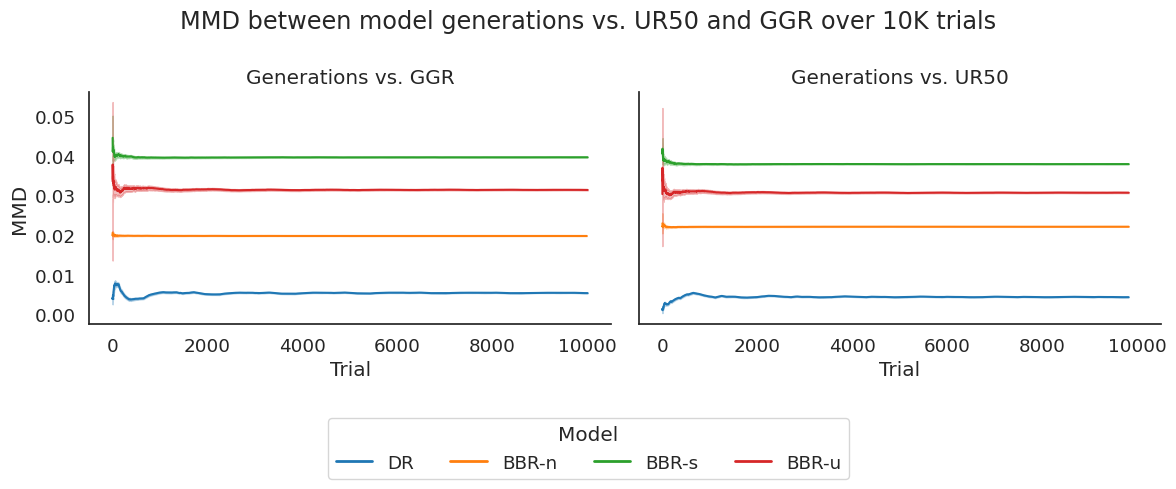

In [4]:

## Plotting the MMD results ##

# Assuming mmd_results_historic_df is your DataFrame.
# Create a color palette and map models to colors.
palette = sns.color_palette("tab10")
models = mmd_results_historic_df['model'].unique()
model_color_map = dict(zip(models, palette))

# Define a custom plotting function for each facet.
def plot_facet(data, color, **kwargs):
    ax = plt.gca()  # get current axis
    # Plot each model's line and fill between the CI.
    for model, group in data.groupby("model"):
        ax.plot(group['sample'], group['mean'], label=model, color=model_color_map[model])
        ax.fill_between(
            group['sample'],
            group['mean'] - group['std_error'] * 1.96,
            group['mean'] + group['std_error'] * 1.96,
            alpha=0.3,
            color=model_color_map[model]
        )
    ax.set_xlabel("Trial")
    ax.set_ylabel("MMD")

# Create a FacetGrid with one column per dataset.
# Adjust the "height" and "aspect" to control the size of each subplot.
g = sns.FacetGrid(mmd_results_historic_df, col="dataset", height=4, aspect=1.5)
g.map_dataframe(plot_facet)

# Set titles for each facet (each will display its dataset name).
g.set_titles(col_template="Generations vs. {col_name}")

# Add a common main title.
plt.subplots_adjust(top=0.85)
g.fig.suptitle("MMD between model generations vs. UR50 and GGR over 10K trials")

# Create a custom legend for the models.
legend_elements = [
    Line2D([0], [0], color=model_color_map[model], lw=2, label=model)
    for model in models
]
g.fig.legend(
    handles=legend_elements,
    title="Model",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=len(models)
)

plt.tight_layout()
plt.show()



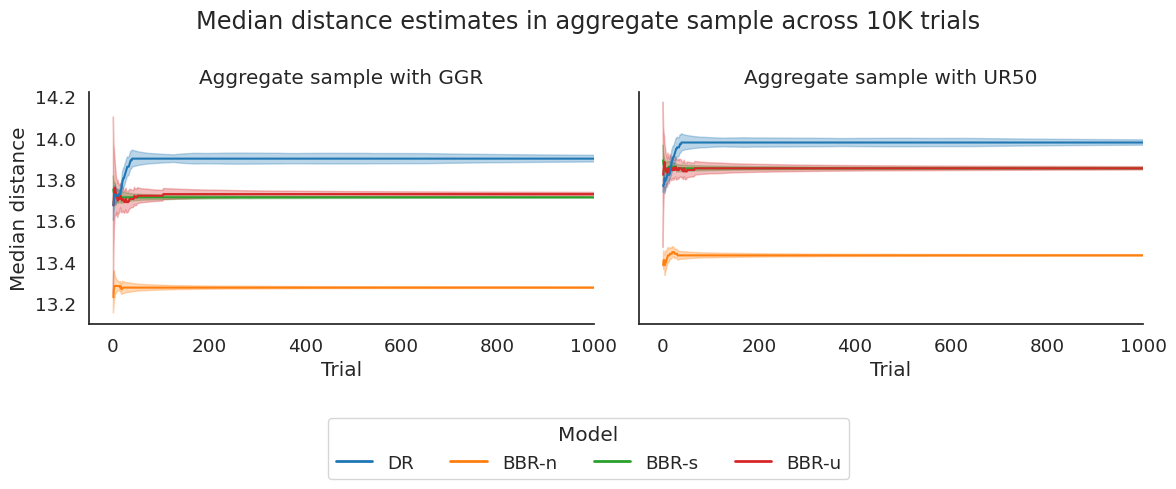


    Estimated median pairwise distances in aggregate samples over 10,000 Monte Carlo trials (sample size = 1,000).
    The median heuristic is used to estimate the bandwidth parameter (σ) of the RBF kernel for Maximum Mean Discrepancy (MMD).
    Shown are the convergence trajectories of the median distance estimate across four generation methods (DR, BBR-n, BBR-s, BBR-u), applied to two different training datasets: GGR and UR50.
    Shaded regions indicate 95% confidence interval. 
    


In [5]:

## Plotting the median distance estimates ##

# Assuming mmd_results_historic_df is your DataFrame.
# Create a color palette and map models to colors.
palette = sns.color_palette("tab10")
models = mmd_results_historic_df['model'].unique()
model_color_map = dict(zip(models, palette))

# Define a custom plotting function for each facet.
def plot_facet(data, color, **kwargs):
    ax = plt.gca()  # get current axis
    # Plot each model's line and fill between the CI.
    for model, group in data.groupby("model"):
        ax.plot(group['sample'], group['mean'], label=model, color=model_color_map[model])
        ax.fill_between(
            group['sample'],
            group['mean'] - group['std_error'] * 1.96,
            group['mean'] + group['std_error'] * 1.96,
            alpha=0.3,
            color=model_color_map[model]
        )
    ax.set_xlabel("Trial")
    ax.set_ylabel("Median distance")

# Create a FacetGrid with one column per dataset.
# Adjust the "height" and "aspect" to control the size of each subplot.
g = sns.FacetGrid(sigma_results_historic_df, col="dataset", height=4, aspect=1.5)
g.map_dataframe(plot_facet)

# Set titles for each facet (each will display its dataset name).
g.set_titles(col_template="Aggregate sample with {col_name}")

# Add a common main title.
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Median distance estimates in aggregate sample across 10K trials")

# Create a custom legend for the models.
legend_elements = [
    Line2D([0], [0], color=model_color_map[model], lw=2, label=model)
    for model in models
]
g.fig.legend(
    handles=legend_elements,
    title="Model",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=len(models)
)
# plt.xscale("log")
plt.xlim(-50,1_000)
plt.tight_layout()
plt.show()
print(

    """
    Estimated median pairwise distances in aggregate samples over 10,000 Monte Carlo trials (sample size = 1,000).
    The median heuristic is used to estimate the bandwidth parameter (σ) of the RBF kernel for Maximum Mean Discrepancy (MMD).
    Shown are the convergence trajectories of the median distance estimate across four generation methods (DR, BBR-n, BBR-s, BBR-u), applied to two different training datasets: GGR and UR50.
    Shaded regions indicate 95% confidence interval. 
    """
)



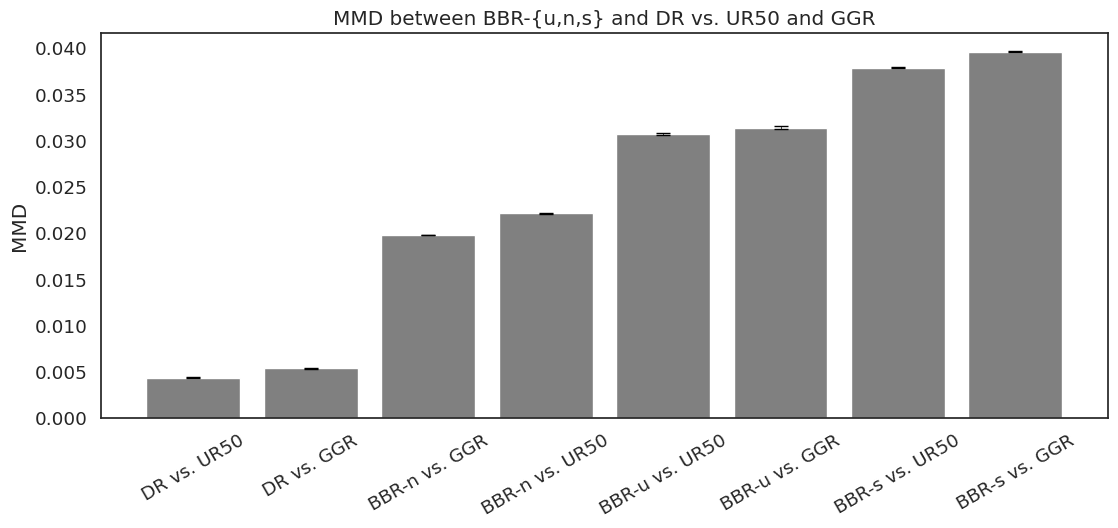

In [6]:


## Plot Final MMD Results Bar Charts ##

mmd_results_df = pd.DataFrame([{'scenario':d,'mean':mmd_results[d]['means'][-1], 'std_error':mmd_results[d]['std_errors'][-1]} for d in mmd_results.keys()])
mmd_results_df['95% CI'] = mmd_results_df.apply(lambda x: (x['mean'] - 1.96*x['std_error'], x['mean'] + 1.96*x['std_error']), axis=1)

mmd_results_df = mmd_results_df.replace({"GIGAREF_CLUSTERED_10M":"GGR",
                        "UNIREF50_10M":"UR50",
                        "RFDIFFUSION_UNFILTERED":"BBR-u",
                        "RFDIFFUSION_BOTH_FILTER":"BBR-n",
                        "RFDIFFUSION_SCRMSD":"BBR-s",
                        "DAYHOFF":"DR",
                        "_": " vs. "
                        },
                        regex=True
).sort_values(by='mean', ascending=True)

mmd_results_df.to_parquet('/mnt/blob/dayhoff/data/mmd_results_v2/mmd_results.parquet',index=False)
mmd_results_df.to_parquet('../data/mmd_results_v2/mmd_results.parquet',index=False)


mmd_results_df = pd.read_parquet('../data/mmd_results_v2/mmd_results.parquet')

plt.figure(figsize=(13, 5))
sns.barplot(x='scenario', y='mean', data=mmd_results_df, color="grey", errorbar=None)
plt.errorbar(mmd_results_df['scenario'],mmd_results_df['mean'], yerr=mmd_results_df['std_error']*1.96, fmt='.', capsize=5,markersize=0, ecolor='black', elinewidth=0.5)
# sns.despine()
plt.xticks(rotation=30)
plt.title("MMD between BBR-{u,n,s} and DR vs. UR50 and GGR")
plt.ylabel("MMD")
plt.xlabel("")
plt.show()
